# Transfer learning with Keras models

We don't have enough data to train an efficient Convolutional Neural Network, but keras has provided a set of pretrained models whose weights could be downloaded from ImageNets, so we can reuse these models to do transfer learning.

In [3]:
import os
import sys
import time
import random

import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.preprocessing import scale
# from imgaug import augmenters as iaa

from tensorflow.keras.applications.vgg16 import VGG16
# from tensorflow.keras.applications.vgg19 import VGG19
# from tensorflow.keras.applications.resnet50 import ResNet50
# from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import Input, Flatten, Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau, Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator # data augmentation

from sklearn.model_selection import train_test_split

In [4]:
# train on GPU
import keras.backend.tensorflow_backend as tf_backend
tf_backend.set_session(tf.Session(config=tf.ConfigProto(device_count={'gpu':0})))

Using TensorFlow backend.


# Preprocessing

In [5]:
# load images
batch_size = 32
epochs = 1000
img_size = 224 # image size

In [6]:
images = [] # images
labels = [] # labels
label = 0
data_path = "./Data/"
folders = os.listdir(data_path)
for folder in tqdm(folders):
    folder_path = folder + '/'
    img_files = os.listdir(data_path + folder_path)
    for img_file in img_files:
        image = cv2.imread(data_path + folder_path + img_file) # read image
        image = cv2.resize(image, (img_size, img_size)) # resize image
        images.append(image) # append image to list images
        labels.append(label) # append label to list labels
    label += 1

num_class = label
images = np.asarray(images) # list to np.ndarray
labels = np.asarray(labels) # list to np.ndarray

100%|██████████| 17/17 [00:08<00:00,  2.31it/s]


In [7]:
print(images.shape)

(683, 224, 224, 3)


In [8]:
# one hot encoding
print(labels.shape)
labels = to_categorical(labels, num_classes=num_class, dtype='int8')
print(labels.shape)

(683,)
(683, 17)


## Image Normalization

In [9]:
def PlotImages(X):
    fig, axes = plt.subplots(3, 3, figsize=(8, 8))
    axes = axes.flatten()
    for i in tqdm(range(9)):
        axes[i].imshow(X[i])
        axes[i].set_xticks(())
        axes[i].set_yticks(())
    plt.tight_layout()

100%|██████████| 9/9 [00:00<00:00, 353.68it/s]


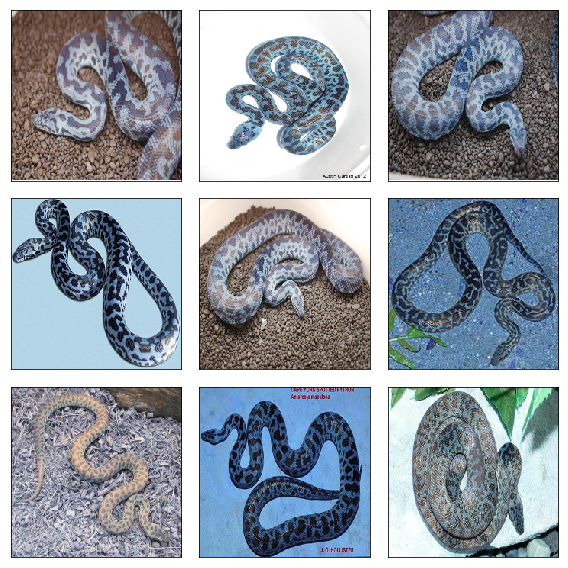

In [10]:
PlotImages(images)

In [11]:
images = images.astype('float64') # int8 to float64

for i in range(len(images)): # normalization
#     mean = images[i].mean()
#     std = images[i].std()
#     images[i] = (images[i] - mean) / std
    for channel in range(3):
        images[i,:,:,channel] = scale(images[i,:,:,channel])

  0%|          | 0/9 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats 

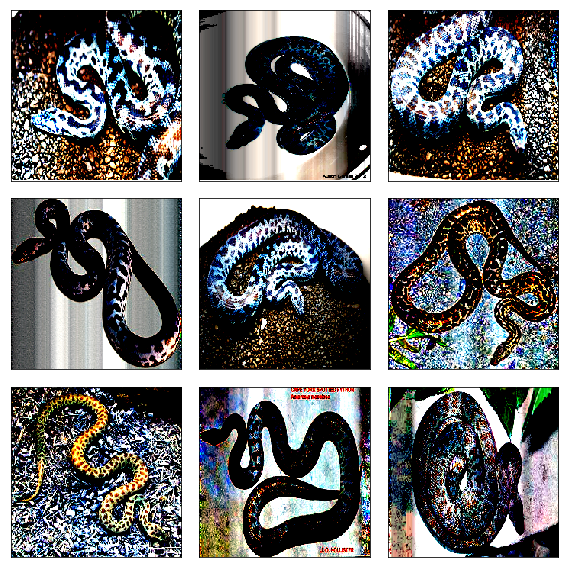

In [12]:
PlotImages(images)

## Split train and validation data

In [13]:
x_train, x_val, y_train, y_val = train_test_split(images, labels, test_size=0.1, random_state=6)

In [14]:
print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)

(614, 224, 224, 3)
(69, 224, 224, 3)
(614, 17)
(69, 17)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]


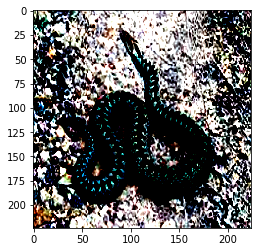

In [15]:
print(y_train[0])
plt.imshow(x_train[0])

## Data Augmentation

In [16]:
datagen = ImageDataGenerator(featurewise_center=True,
                             featurewise_std_normalization=True,
                             rotation_range=15,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             horizontal_flip=True)
datagen.fit(x_train)

## Callbacks

In [18]:
# callback function for plotting loss 
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.accuracy = {'batch':[], 'epoch':[]}
        self.val_loss = {'batch':[], 'epoch':[]}
        self.val_acc = {'batch':[], 'epoch':[]}

    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('acc'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_acc'))

    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('acc'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_acc['epoch'].append(logs.get('val_acc'))

    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        plt.figure()
        # acc
        plt.plot(iters, self.accuracy[loss_type], '#9933ff', label='train accuracy')
        # loss
        plt.plot(iters, self.losses[loss_type], '#1404FB', label='train loss')
        if loss_type == 'epoch':
            # val_acc
            plt.plot(iters, self.val_acc[loss_type], '#ff0d00', label='validation accuracy')
            # val_loss
            plt.plot(iters, self.val_loss[loss_type], '#ff9a00', label='validation loss')
        plt.grid(True)
        plt.xlabel(loss_type)
        plt.ylabel('accuracy and loss')
        plt.legend(loc="upper right")
        plt.show()

In [21]:
class ReduceLearningRate(Callback):
    def __init__(self, lr=1e-3, epoch_batch=20):
        self.lr = lr
        self.epoch = 0
        self.epoch_batch = epoch_batch
        
    def on_epoch_end(self, batch, logs={}):
        self.epoch += 1
        if self.epoch == self.epoch_batch:
            self.epoch = 0
            self.lr *= 0.5
            logs['lr'] = self.lr
            print('\nLearning Rate reduced to {}\n'.format(self.lr))

In [22]:
# callbacks

# check point
filepath = 'Snake-VGG16.hdf5'
model_check_point = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True)

# tensorboard
tensor_board = TensorBoard(log_dir='log', write_images=1, histogram_freq=1)  

# learning rate reduction
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=5, verbose=1, factor=0.5, min_lr=1e-9)

# plot loss
loss_history = LossHistory()

callbacks = [model_check_point, tensor_board, learning_rate_reduction, loss_history]

reduce_learning_rate = ReduceLearningRate()
callbacks = [reduce_learning_rate]

# Training

## Build Model

In [23]:
# read pretrained model, download weights from ImageNet
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

# freeze layers
for layer in base_model.layers:
    layer.trainable = False

# add top and prediction layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(16, activation='relu')(x)
x = Dropout(0.05)(x)
predictions = Dense(num_class, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [24]:
model.compile(optimizer=Adam(lr=1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

!rm -r log

In [ ]:
history = model.fit(x_train, y_train, batch_size=batch_size,
                    epochs=epochs, verbose=1,
                    validation_data = (x_val, y_val),
                    callbacks=callbacks)

Train on 614 samples, validate on 69 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/1000
614/614 [==============================] - 5s 7ms/sample - loss: 2.8620 - acc: 0.0863 - val_loss: 2.7957 - val_acc: 0.1449
Epoch 2/1000
614/614 [==============================] - 2s 3ms/sample - loss: 2.7363 - acc: 0.1498 - val_loss: 2.7519 - val_acc: 0.1449
Epoch 3/1000
614/614 [==============================] - 2s 3ms/sample - loss: 2.6517 - acc: 0.1792 - val_loss: 2.6807 - val_acc: 0.2029
Epoch 4/1000
614/614 [==============================] - 2s 3ms/sample - loss: 2.5619 - acc: 0.2052 - val_loss: 2.6288 - val_acc: 0.1884
Epoch 5/1000
576/614 [===========================>..] - ETA: 0s - loss: 2.4794 - acc: 0.2517

In [ ]:
model.compile(optimizer=Adam(lr=1e-7),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                              steps_per_epoch=len(x_train) // batch_size,
                              epochs = epochs, verbose=1,
                              validation_data = (x_val, y_val),
                               callbacks=callbacks)

In [ ]:
loss_history.loss_plot('epoch')